# Section 1: Perform Quantum Operations
## 1.1 Define Pauli Operators

In [3]:
import qiskit.quantum_info as qi

# Method 1: Create Pauli operator from string
pauli1 = qi.Pauli('XZ') #'XZ' = X on qubit 1, Z on qubit 0 (little-endian)
#Note: Can also create from another Pauli object, ScalarOp, or QuantumCircuit with only Pauli gates (copy constructor).

# Method 2: Create from matrix (Z-gate, X-gate)
pauli2 = qi.Pauli(([0, 1], [0, 1])) # We apply Z & X = Y on qubit 1, nothing on qubit 0, thus the string 'YI'.

print(pauli1)
print(pauli2)

XZ
YI


## 1.2 Apply Quantum Operations
this section prolly needs some more work

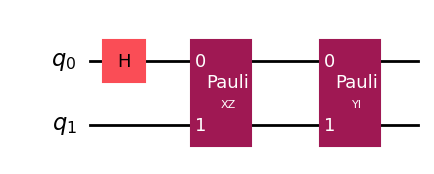

In [4]:
from qiskit import QuantumCircuit

qc = QuantumCircuit(2)

qc.h(0)

qc.append(pauli1.to_instruction(), [0, 1])
qc.append(pauli2.to_instruction(), [0, 1])

qc.draw('mpl')

# Section 2: Visualize quantum circuits, measurements, and states
## 2.1 Visualize Quantum Circuits

In [5]:
print(qc)

     ┌───┐┌────────────┐┌────────────┐
q_0: ┤ H ├┤0           ├┤0           ├
     └───┘│  Pauli(XZ) ││  Pauli(YI) │
q_1: ─────┤1           ├┤1           ├
          └────────────┘└────────────┘


In [6]:
qc.draw()

┌───┐┌────────────┐┌────────────┐
q_0: ┤ H ├┤0           ├┤0           ├
     └───┘│  Pauli(XZ) ││  Pauli(YI) │
q_1: ─────┤1           ├┤1           ├
          └────────────┘└────────────┘

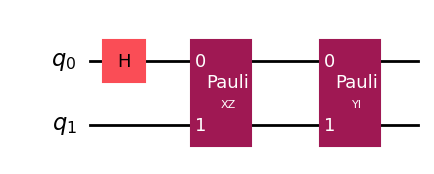

In [7]:
qc.draw('mpl', filename='test-circuit.png') #Save file as well

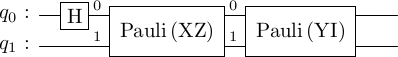

In [8]:
qc.draw('latex')

## 2.2 Visualize Quantum Measurements

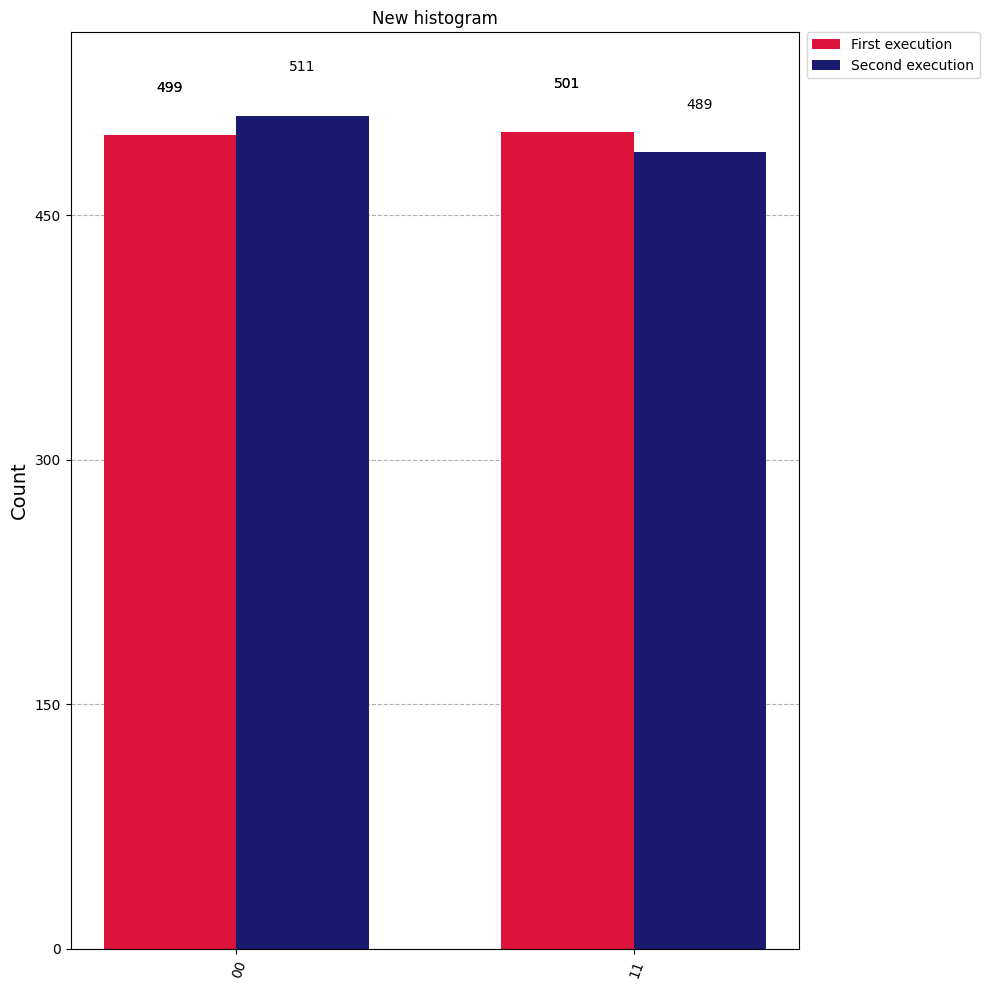

In [9]:
from qiskit.visualization import plot_histogram
 
counts1 = {'00': 499, '11': 501}
counts2 = {'00': 511, '11': 489}
data = [counts1, counts2]
 
legend = ['First execution', 'Second execution']
title = 'New histogram'
figsize = (10,10)
color=['crimson','midnightblue']
plot_histogram(data, legend=legend, title=title, figsize=figsize, color=color)

Statevector([0.-0.70710678j, 0.+0.70710678j, 0.+0.j        ,
             0.+0.j        ],
            dims=(2, 2))
DensityMatrix([[ 0.5+0.j, -0.5+0.j,  0. +0.j,  0. +0.j],
               [-0.5+0.j,  0.5+0.j,  0. +0.j,  0. +0.j],
               [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j],
               [ 0. +0.j,  0. +0.j,  0. +0.j,  0. +0.j]],
              dims=(2, 2))


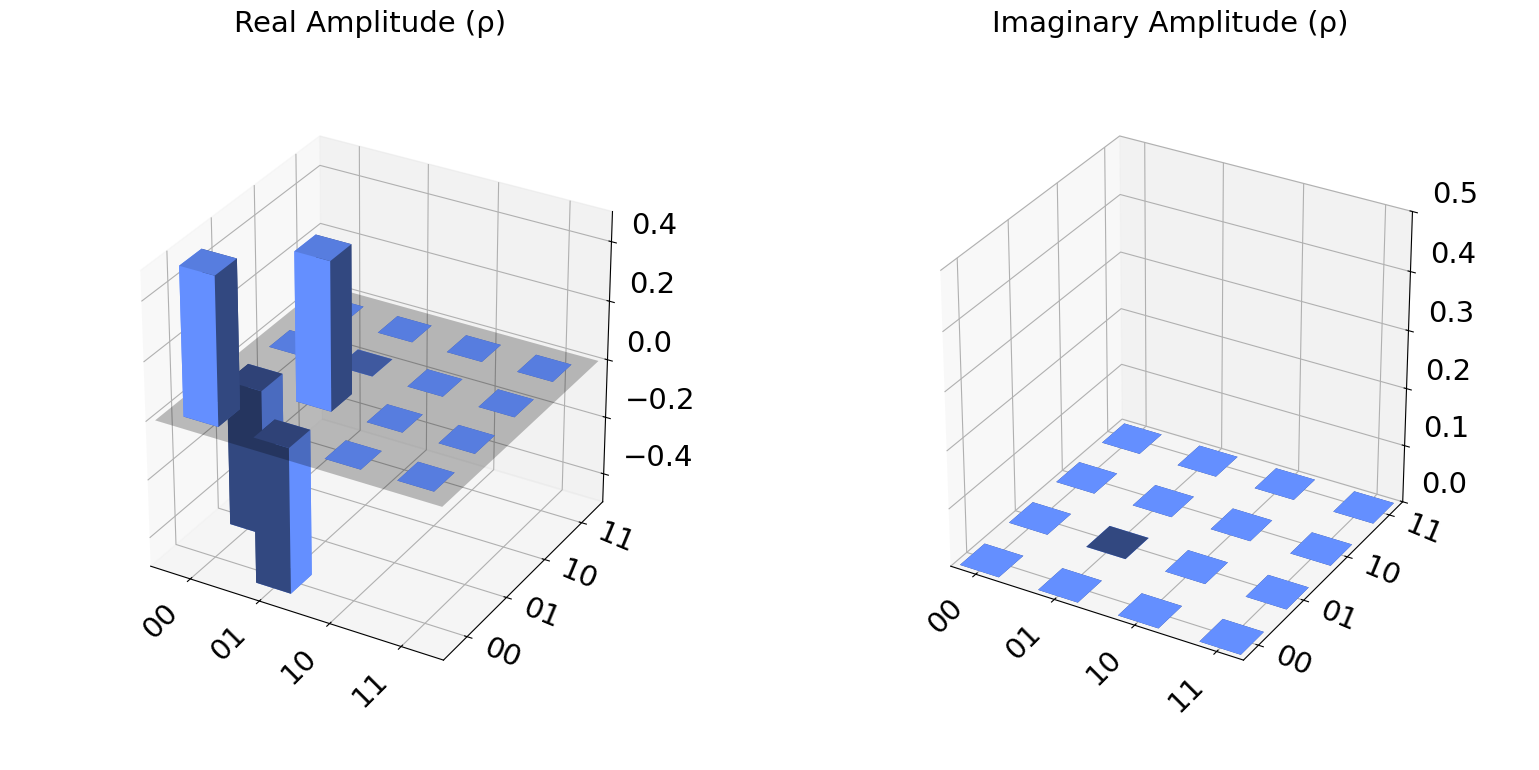

In [10]:
from qiskit.quantum_info import Statevector, DensityMatrix
from qiskit.visualization import plot_state_city

state = Statevector(qc)
print(state)
matrix = DensityMatrix(qc)
print(matrix)
plot_state_city(state)

## 2.3 Visualize Quantum States

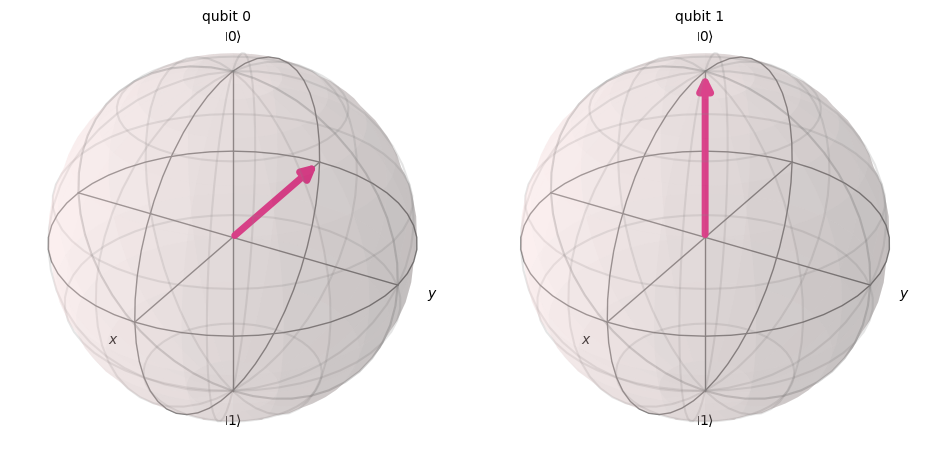

In [11]:
from qiskit.visualization import plot_bloch_multivector, plot_state_qsphere

plot_bloch_multivector(state) #plot_bloch_vector for single qubit

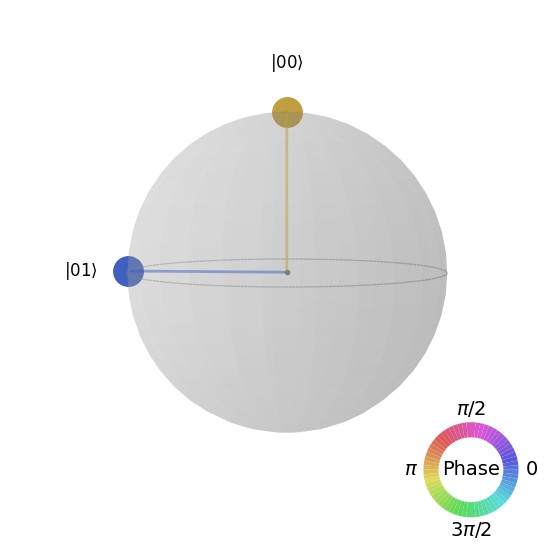

In [12]:
plot_state_qsphere(state)

# Section 3: Create Quantum Circuits
## 3.1 Construct dynamic circuits
mb add: check which backends support dynamic circuits??

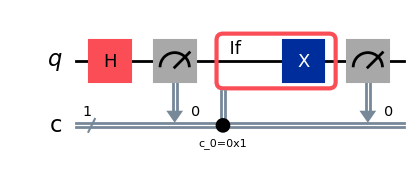

In [13]:
# if statement & with statement

circuit = QuantumCircuit(1, 1)
 
circuit.h(0)
# Use MidCircuitMeasure() if it's supported by the backend.
# circuit.append(MidCircuitMeasure(), [q0], [c0])
circuit.measure(0, 0)

# conditional operation if the measurement was 1
with circuit.if_test((0, 1)): # if classical bit 0 is 1
    circuit.x(0)
circuit.measure(0, 0) #measure qubit 0 -> classical bit 0
circuit.draw("mpl")

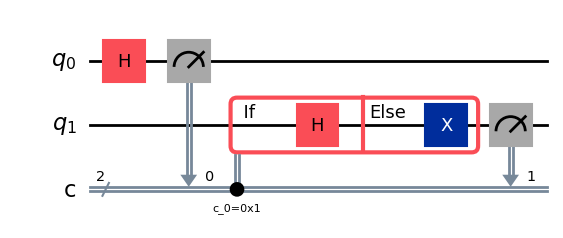

In [14]:
# example with else statement

circuit = QuantumCircuit(2, 2)
 
circuit.h(0)
circuit.measure(0, 0)
with circuit.if_test((0, 1)) as else_:
    circuit.h(1)
with else_:
    circuit.x(1)
circuit.measure(1, 1)
 
circuit.draw("mpl")

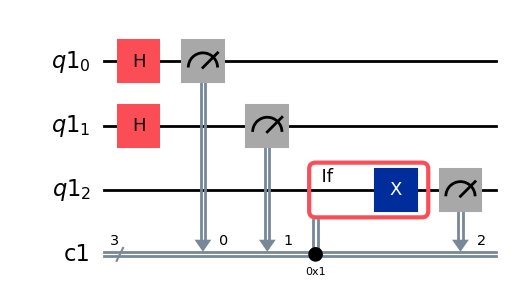

In [15]:
from qiskit.circuit import QuantumRegister, ClassicalRegister

qubits = QuantumRegister(3)
clbits = ClassicalRegister(3)
circuit = QuantumCircuit(qubits, clbits)
(q0, q1, q2) = qubits
(c0, c1, c2) = clbits
 
circuit.h([q0, q1])
circuit.measure(q0, c0)
circuit.measure(q1, c1)
with circuit.if_test((clbits, 0b001)): #qubit 0 is 1, qubit 1 is 0
    circuit.x(q2)
circuit.measure(q2, c2)
 
circuit.draw("mpl")

## 3.2 Construct Parameterized Circuits

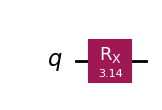

In [16]:
from qiskit.circuit import Parameter

# Parameter

# create the parameter -- allows to quickly modify the circuit later
phi = Parameter("phi")
qc = QuantumCircuit(1)
 
# parameterize the rotation
qc.rx(phi, 0)
qc.draw("mpl")
 
# bind the parameters after circuit to create a bound circuit
bc = qc.assign_parameters({phi: 3.14})
bc.draw("mpl")

# Note: Compare parameters with ==, not is

## 3.3 Transpile & Optimize Circuits
1. init
2. layout -- mapping of "virtual" qubits to "physical" qubits (part of ISA of backend)
3. routing -- two-qubit gate operations are not always able to interact. Must perform SWAP operations to do this; finds the near-optimal configuration using SabreSwap.
4. translation -- translates to native basis-gates supported by the backend hardware
5. optimization -- further optimizes after the circuit has been decomposed to its basis gates. optimization levels are 0-3
6. scheduling -- able to insert delays, usually to estimate how long it would take on the actual backend

In [5]:
# Note: Make sure you have saved your IBM Quantum account previously (ibm_account.ipynb -- but with your token)
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService()

# get available backends
print(service.backends())

# Determine basis gates for ibm_fez backend (translation stage)
backend = service.backend("ibm_fez", instance=None, use_fractional_gates=False)
print(backend.operation_names)

[<IBMBackend('ibm_fez')>, <IBMBackend('ibm_torino')>, <IBMBackend('ibm_marrakesh')>]
['delay', 'if_else', 'rz', 'cz', 'measure', 'reset', 'id', 'sx', 'x']


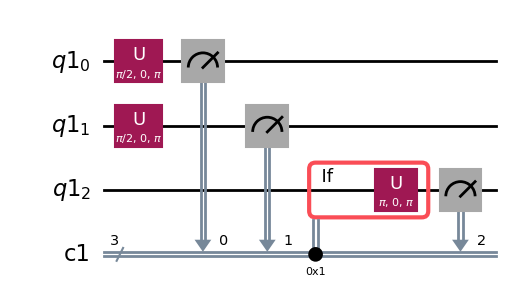

In [20]:
# Circuit using native basis gates (not specific to a hardware)
circuit.decompose().draw('mpl')

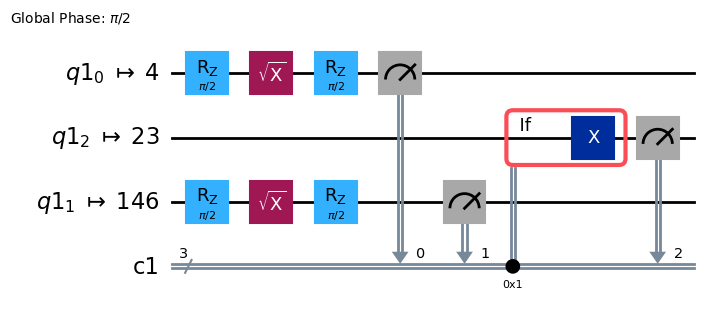

In [21]:
# Let's transpile this circuit to be able to run on hardware (using basis gates of ibm_fez)
from qiskit.transpiler import generate_preset_pass_manager

pass_manager = generate_preset_pass_manager(optimization_level=3, backend=backend)

transpiled_circuit = pass_manager.run(circuit)
transpiled_circuit.draw('mpl')

In [25]:
# Generalized, custom pass managers can also be created (preset pass managers are convenient shortcuts for a specific hardware)
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import Collect2qBlocks,ConsolidateBlocks, UnitarySynthesis
 
basis_gates = ["rx", "ry", "rxx"] # Can choose your own basis gates
custom_pm = PassManager(
    [
        Collect2qBlocks(),
        ConsolidateBlocks(basis_gates=basis_gates),
        UnitarySynthesis(basis_gates),
    ]
)

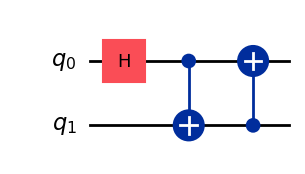

In [26]:
#Example circuit
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.cx(1,0)

qc.draw('mpl')

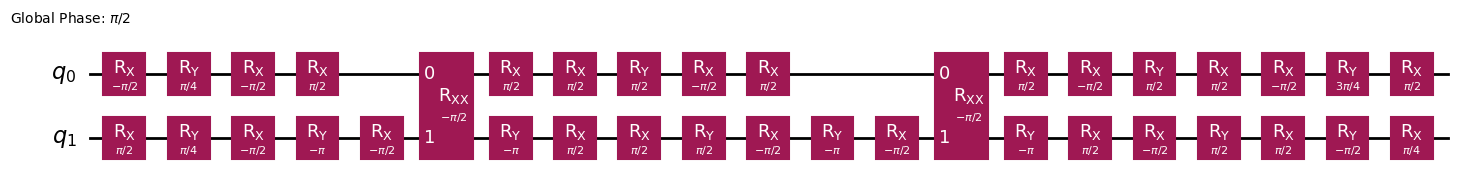

In [27]:
# Custom pass manager in action
transpiled = custom_pm.run(qc)
transpiled.draw('mpl')

In [34]:
# Can also create staged pass managers -- basically one pass manager applied after another. No limit to # of stages.
from qiskit.transpiler import StagedPassManager
from qiskit.transpiler.passes import Unroll3qOrMore, UnitarySynthesis

basis_gates = ["rx", "ry", "rxx"]
init = PassManager(
    [UnitarySynthesis(basis_gates, min_qubits=3), Unroll3qOrMore()]
)
staged_pm = StagedPassManager(
    stages=["init", "translation"], init=init, translation=custom_pm
)

# Can also edit stages dynamically after the fact -- works on preset PM's as well
staged_pm.init = custom_pm

## 3.4 Construct Basic Quantum Circuits
Pretty self-explanatory imo. We've done a lot with this so I'm not going to put anything here.

# Section 4: Run Quantum Circuits
## 4.1 Execution Modes

1. Job Mode:
Single job, how we normally do things.

2. Batch Mode:
Multiple independentally executable jobs run in parallel. If only using 1 QPU, quantum computation cannot be done in parallel but classical can. All jobs are submitted at once.

3. Session Mode:
User has exclusive access of system, no other jobs are able to run. All computations are done sequentially. Good when frequent communication between quantum and classical workflows is needed (i.e. variational quantum algorithms)
(unavailable to open plan users like you and I)

When to choose which: https://quantum.cloud.ibm.com/docs/en/guides/choose-execution-mode 

In [ ]:
from qiskit_ibm_runtime import Batch, EstimatorV2 as Estimator, SamplerV2 as Sampler

# Start a batch job
backend = service.least_busy(operational=True, simulator=False)

# this context manager automatically opens and closes the batch
with Batch(backend=backend, max_time='25m'): #max_time is optional
    estimator = Estimator()
    sampler = Sampler()

    # Normally you would run stuff here -- don't want to waste runtime

#Similarly, for Session you would replace "Batch" with "Session" above  

## 4.2 Qiskit Runtime Primitives & Broadcasting Rules

1. Estimator:
Computes expectation values of an observable.

2. Sampler:
Samples classical output measurement

In [ ]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator

#transpile circuit
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
transpiled_qc = pm.run(qc)
layout = transpiled_qc.layout

#observable
obs = qi.Pauli("XZ").apply_layout(layout) # make sure observable matches qubit layout

estimator = Estimator(mode=backend)
estimator_job = estimator.run([(transpiled_qc, obs)]) #list of (circuit, observable, parameter_values) PUB (primitive unified bloc) tuples
pub_result = estimator_job.result()


In [ ]:
#Dimension of pub_result is (# PUB tuples) x (# observables per PUB tuple) x (# parameter sets per PUB tuple)
# ^ only if parameter sets are rows & observables columns. If same dimension, they do element-wise matching.
print("Expectation value: ", pub_result[0].data.evs)
print("Uncertainty:", pub_result[0].data.stds)
print("Metadata:", pub_result[0].metadata)

Expectation value:  0.9422057264050901
Uncertainty: 0.008166715639027733
Metadata: {'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32}


In [ ]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

qc.measure_all()
transpiled_qc = pm.run(qc)

sampler = Sampler(mode=backend)
sampler_job = sampler.run([(transpiled_qc, [], 256)]) #list of (circuit, parameter_values, shots) PUB tuples
pub_result = sampler_job.result()

In [56]:
print(pub_result[0].data.meas.get_counts())
print(pub_result[0].metadata)

{'00': 544, '10': 431, '11': 27, '01': 22}
{'circuit_metadata': {}}


# Section 5: Use Sampler Primitive

## 5.1 Set sampler primitive options
These options can be found in metadata (empty if default)

In [ ]:
from qiskit_ibm_runtime import SamplerOptions

options = SamplerOptions()

# Sampler options
options.default_shots = 1024
options.dynamical_decoupling.enable = True
options.dynamical_decoupling.sequence_type = "XY4"

# Twirling options
options.twirling.enable_gates = True

options.twirling.enable_measure = True

options.twirling.num_randomizations = 64

options.twirling.strategy = "active-accum"

sampler = Sampler(mode=backend, options=options)
# 

## 5.2 Theoretical Background of Sampler Primitive

### Error mitigaton techniques
1. Dynamical Decoupling -- gates on some qubits cause coherence errors on idling qubits. Send a pulse which cancels out this error, putting it back to identity
2. Pauli Twirling -- Sandwiching the intended gate with two Pauli gates (chosen randomly) such that the effect is the same. When sampling the circuit the random different Pauli gates chosen mitigate the noise.
3. Twirled Readout Error Extinction (TREX) -- randomly replaces measurement gates with a twirled measurement gate (X, meas, CNOT) to mitigate measurement noise.
4. Zero Noise Extrapolation (ZNE) -- Executes circuit many times at different noise rates, extrapolates to determine this noise. Not guaranteed to be unbiased.
5. Probabalistic Error Cancellation (PEC) -- Ideal circuit can be replaced with an ensemble of noisy circuits, which are sampled from a certain probability distribution to determine expectation value. Often has a large sampling overhead.

# Section 6: Using the Estimator Primitive

## 6.1 Estimator Primitive Options
Pretty much same as above for sampler

In [ ]:
from qiskit_ibm_runtime import EstimatorV2 as Estimator, EstimatorOptions

# Initialize options
options = EstimatorOptions()

# Resilience
options.resilience_level = 2 

# ZNE
options.resilience.zne.noise_factors = [1, 1.5, 2]
options.resilience.zne.extrapolator = "polynomial_degree_2"

# Twirling
options.twirling.num_randomizations = 64

# Initialize Estimator with these options
estimator = Estimator(mode=backend, options=options)

## 6.2 Theoretical Background of Estimator Primitive
^ done above (error mitigation techniques and what an estimator is), u know this twin

# Section 7: Retrieve & Analyze the Results of Quantum Circuits

## 7.1 Retrieve Previous Session Results


In [ ]:
import datetime
from qiskit_ibm_runtime import QiskitRuntimeService
 
 # Get recent jobs
three_months_ago = datetime.datetime.now() - datetime.timedelta(days=90)
 
service = QiskitRuntimeService()
jobs_in_last_three_months = service.jobs(created_after=three_months_ago)
jobs_in_last_three_months[:3]  # show first three jobs

[<RuntimeJobV2('d5ep4figim5s73aesil0', 'sampler')>,
 <RuntimeJobV2('d5ep39qgim5s73aeshag', 'sampler')>,
 <RuntimeJobV2('d5ep37vsm22c73brkj30', 'sampler')>]

In [64]:
# get job ID of a successful job

successful_job = next(
    j for j in service.jobs(limit=1000) if j.status() == "DONE"
)
job_id = successful_job.job_id()
print(job_id)

# Retrieve job by ID & get results
retrieved_job = service.job(job_id)
result = retrieved_job.result()
print(result)

d5ep4figim5s73aesil0
PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=2>), meas2=BitArray(<shape=(), num_shots=1024, num_bits=2>), meas3=BitArray(<shape=(), num_shots=1024, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2026-01-06 22:53:59', stop='2026-01-06 22:54:00', size=1024>)])}, 'version': 2})


In [65]:
# Save to & load from disk
import json
from qiskit_ibm_runtime import RuntimeEncoder, RuntimeDecoder
 
with open("result.json", "w") as file:
    json.dump(retrieved_job.result(), file, cls=RuntimeEncoder)

with open("result.json", "r") as file:
    result = json.load(file, cls=RuntimeDecoder)
 
print(result)

PrimitiveResult([SamplerPubResult(data=DataBin(meas=BitArray(<shape=(), num_shots=1024, num_bits=2>), meas2=BitArray(<shape=(), num_shots=1024, num_bits=2>), meas3=BitArray(<shape=(), num_shots=1024, num_bits=2>)), metadata={'circuit_metadata': {}})], metadata={'execution': {'execution_spans': ExecutionSpans([DoubleSliceSpan(<start='2026-01-06 22:53:59', stop='2026-01-06 22:54:00', size=1024>)])}, 'version': 2})


## 7.2 Monitor Jobs

In [67]:
#Job & Session objects have a status() method
print(estimator_job.status())

DONE


# Section 8: Operate with OpenQASM

OpenQASM (Open Quantum Assembly Language) is the "assembly language" for quantum computing. Essentially any quantum circuit can be represented with an OpenQASM program/string

## 8.1 Structure types in OpenQASM 3

- Qubit: Just a normal qubit, variable name is global  
qubit name; //declare a qubit  
qubit[size] name; //declare a qubit register  

- Physical Qubit: The actual hardware, names are preset and global  
$[NUM]  

- Classical Types: bit, uint, int, float, void, bool  
bit[20] //20-bit register  
uint[32] //32-bit integer

- Angle: Special type for hardware efficiency.  
Angle (in radians) is $val*\frac{2*\pi}{2^{\text{size}}}$

- Complex Numbers: Acts as two values of float[size] type  
complex[float[size]] name;  
name = 2.5 + 3im;  

- Duration: Represents timing values
duration second = 1000ms;   
duration thousand_cycles = 1000dt; //dt is system time-step

- Array: Follows normal array rules  
array[int[32], 5] name;

## 8.2 Interpret OpenQASM Semantics

## 8.3 Interoperate OpenQASM with Qiskit

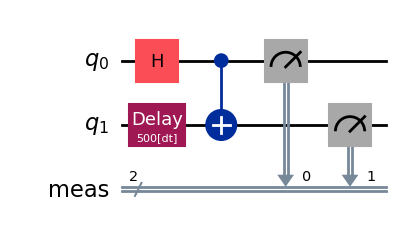

In [2]:
import qiskit.qasm3 as qasm

# Import OpenQASM 3 program to Qiskit
qasm_circuit = qasm.load("sample_openqasm_program.txt")
#qasm.loads(program_string)
# ^ can also load from entire program string
qasm_circuit.draw('mpl')

In [3]:

# to save to file:
#file = open("my_file.txt", "w")
#qasm.dump(qc, f)
#file.close()

#this just puts it into a string
qasm.dumps(qasm_circuit)

'OPENQASM 3.0;\ninclude "stdgates.inc";\nbit[2] meas;\nqubit[2] q;\nh q[0];\ndelay[500dt] q[1];\ncx q[0], q[1];\nmeas[0] = measure q[0];\nmeas[1] = measure q[1];\n'

## 8.4 Interact with the Qiskit IBM Runtime REST API

The rest API is what QiskitRuntimeService actually makes requests to.

In [ ]:
import requests
#NOTE: Pretty sure this doesn't work on the open plan so
 
account = service.active_account()
token = account.get('token')
crn = account.get('instance')

print(token)
print(crn)

reqUrl = "https://quantum.cloud.ibm.com/api/v1/backends"

headersList = {
  "Accept": "application/json",
  "Authorization": f"Bearer {token}",
  "Service-CRN": f"{crn}",
  "IBM-API-Version": "2025-05-01"
}
 
payload = ""
 
response = requests.request("GET", reqUrl, data=payload,  headers=headersList)
 
print(response.json())

7pPECb0zlWg0vc3ZSc_y4ep-21Qn0LgZ7wKMhUHMh7ud
crn:v1:bluemix:public:quantum-computing:us-east:a/70d20a648af54c0ab2945b92da4302eb:cdbaf205-8430-439b-b060-4353daaa68dc::
{'errors': [{'code': 1219, 'message': 'Error authenticating user.', 'solution': 'Your IBM Quantum API token might be incorrect, expired, or revoked.\nLog in to IBM Quantum Platform website and navigate to your account settings to generate a new API token.\nUse IBMProvider.save_account(`APIKEY`, overwrite=True) to save the new API key, overwriting any outdated or incorrect credentials.', 'more_info': 'https://cloud.ibm.com/apidocs/quantum-computing#error-handling'}], 'trace': 'd5ca65a8-c4b7-420f-ae75-ca4a7a9dd57a'}
